In [3]:
pip install numpy pandas matplotlib seaborn scikit-learn xgboost optuna shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [7]:
# Import the necessary library to upload files
from google.colab import files

# Upload the dataset
print("Please upload the 'IMDb Movies India.csv' file.")
uploaded = files.upload()

# Confirm the upload
if len(uploaded) > 0:
    print("File uploaded successfully!")
else:
    print("No file was uploaded. Please try again.")

Please upload the 'IMDb Movies India.csv' file.


Saving IMDb Movies India.csv.csv to IMDb Movies India.csv (2).csv
File uploaded successfully!


Reading file: IMDb Movies India.csv (2).csv


[I 2024-12-18 16:32:26,484] A new study created in memory with name: no-name-c14f2aab-4ec4-42b7-bf92-67b75e6bde18


   Year  Duration  Rating  Votes  Director Average Rating  \
1  2019     109.0     7.0      8                 7.000000   
3  2019     110.0     4.4     35                 4.400000   
5  1997     147.0     4.7    827                 5.313333   
6  2005     142.0     7.4   1086                 7.383333   
8  2012      82.0     5.6    326                 5.600000   

   Lead Actor Average Rating  Genre1  Genre2  Genre3  
1                   6.850000       0       0       0  
3                   5.420000       1       1       1  
5                   4.788889       1       2       2  
6                   5.435000       0       1       3  
8                   5.600000       2       3       4  
(5659, 9)
Year                         0
Duration                     0
Rating                       0
Votes                        0
Director Average Rating      0
Lead Actor Average Rating    0
Genre1                       0
Genre2                       0
Genre3                       0
dtype: int64


[I 2024-12-18 16:32:29,100] Trial 0 finished with value: 0.7604625579014064 and parameters: {'n_estimators': 625, 'max_depth': 3, 'learning_rate': 0.07332940696144247, 'subsample': 0.9604512868162826, 'colsample_bytree': 0.6997476391720987, 'reg_alpha': 4.7316427251450595, 'reg_lambda': 3.447903605306685}. Best is trial 0 with value: 0.7604625579014064.
[I 2024-12-18 16:32:29,717] Trial 1 finished with value: 0.7576568021252809 and parameters: {'n_estimators': 649, 'max_depth': 5, 'learning_rate': 0.047920404617456294, 'subsample': 0.7353649929712466, 'colsample_bytree': 0.8876072665843397, 'reg_alpha': 3.5389452338598995, 'reg_lambda': 4.227222354847132}. Best is trial 0 with value: 0.7604625579014064.
[I 2024-12-18 16:32:30,296] Trial 2 finished with value: 0.7640775001519713 and parameters: {'n_estimators': 822, 'max_depth': 4, 'learning_rate': 0.022073951842541413, 'subsample': 0.8378615653759827, 'colsample_bytree': 0.9551151615380712, 'reg_alpha': 0.12913516348559084, 'reg_lambda

Best trial:
  Value: 0.7655103553258893
  Params: 
    n_estimators: 427
    max_depth: 6
    learning_rate: 0.01795993051059818
    subsample: 0.7709741094322268
    colsample_bytree: 0.8098587031204874
    reg_alpha: 2.4642290998799132
    reg_lambda: 5.880943022616894
Test MAE: 0.4686900263540315


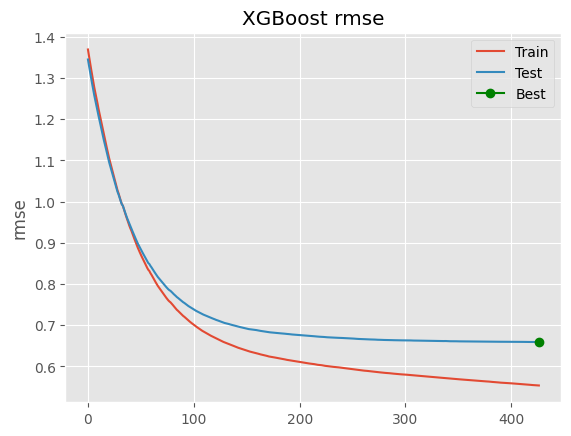

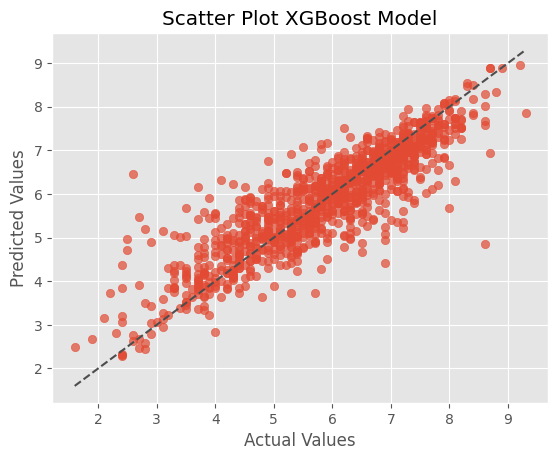

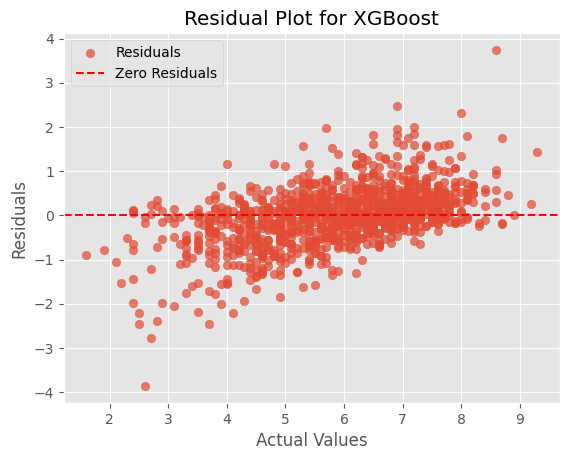

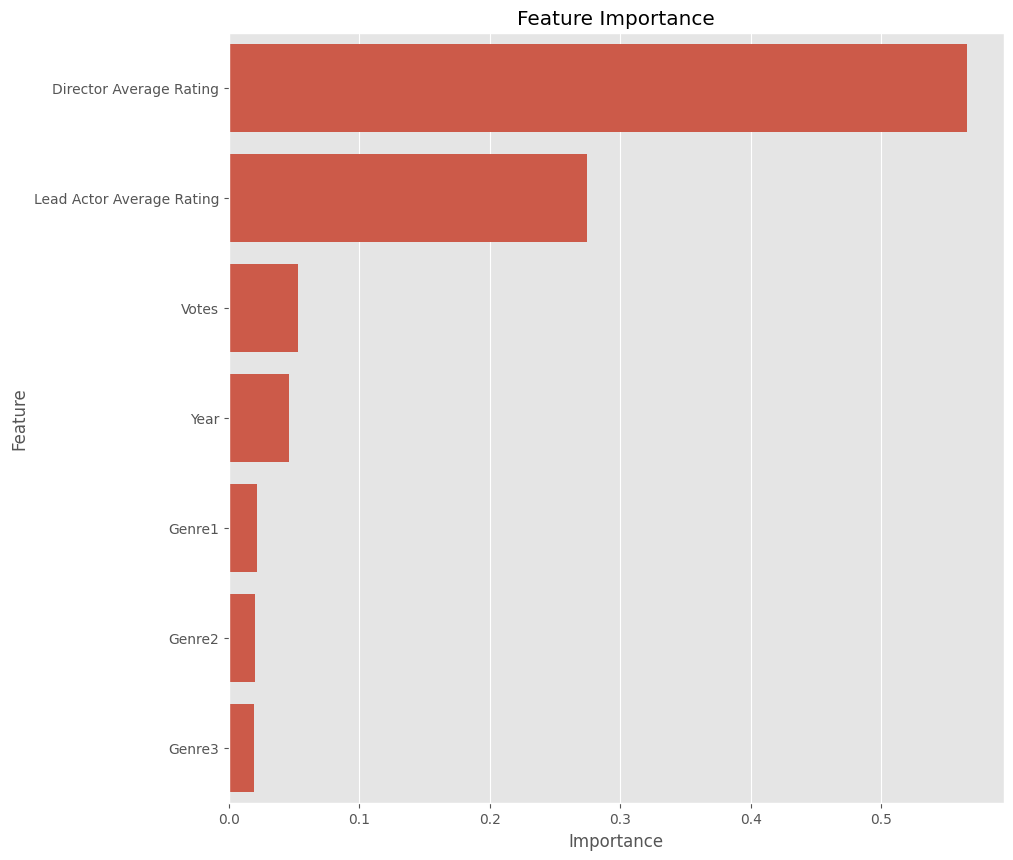

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import optuna
import shap
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

# Dynamically retrieve the uploaded filename
import io
uploaded_filename = list(uploaded.keys())[0]  # Get the first key (filename) from the uploaded dictionary
print(f"Reading file: {uploaded_filename}")

# Read the dataset from the uploaded file
df = pd.read_csv(io.BytesIO(uploaded[uploaded_filename]), encoding='ISO-8859-1').drop(columns='Name')

# Data Cleaning and Preprocessing
df.dropna(inplace=True)

# Remove () and convert dtype if year to int
df['Year'] = df['Year'].str.replace('(', '').str.replace(')', '').astype(int)

# Convert Duration to float
df['Duration'] = df['Duration'].str.split(' ', expand=True)[0].astype(float)

# Convert Votes to int
df['Votes'] = df['Votes'].str.replace(',', '').astype(int)

# Calculate Director Average Rating
director_avg_rating = {}
for index, row in df.iterrows():
    director = row['Director']
    rating = row['Rating']
    if director in director_avg_rating:
        director_avg_rating[director]['sum'] += rating
        director_avg_rating[director]['count'] += 1
    else:
        director_avg_rating[director] = {'sum': rating, 'count': 1}

df['Director Average Rating'] = df['Director'].apply(lambda x: director_avg_rating[x]['sum'] / director_avg_rating[x]['count'])

# Add a column 'Lead Actor Average Rating'
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 1'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}

def calculate_lead_actor_average(row):
    actors = row['Actor 1'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

df['Lead Actor Average Rating'] = df.apply(calculate_lead_actor_average, axis=1)

# Split Genre into three columns
df['Genre1'] = df.Genre.str.split(',', expand=True)[0]
df['Genre2'] = df.Genre.str.split(',', expand=True)[1]
df['Genre3'] = df.Genre.str.split(',', expand=True)[2]

# Drop unnecessary columns
df = df.drop(columns=['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'])

# Fill NaN values with 0
df = df.fillna(0)

# Ensure Genre columns are filled
for i in df.index:
    if df.at[i, 'Genre2'] == 0:
        df.at[i, 'Genre2'] = df.at[i, 'Genre1']
    elif df.at[i, 'Genre3'] == 0:
        df.at[i, 'Genre3'] = df.at[i, 'Genre2']

# Factorize categorical columns
for col in ['Genre1', 'Genre2', 'Genre3']:
    df[col], _ = pd.factorize(df[col])

# Display the cleaned dataset
print(df.head())
print(df.shape)
print(df.isna().sum())

# Define target variable
target = 'Rating'

# Split the dataset into features and target
X = df.drop(columns=[target, 'Duration'])
y = df[target]

# Scale the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
    }

    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_normal = XGBRegressor(**best_params)

xgb_normal.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

# Make predictions on the test set
y_pred_test = xgb_normal.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)

print("Test MAE:", mae)

# Plotting the results
results = xgb_normal.evals_result()
val_rmse = results["validation_1"]['rmse']
best_epoch = min(val_rmse)
i_best_epoch = val_rmse.index(best_epoch)
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot RMSE
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.plot(i_best_epoch, best_epoch, marker="o", color="green", label="Best")
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_test, alpha=0.7, label='Real')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', c='.3')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot XGBoost Model')
plt.show()

# Residual plot
residuals = y_test - y_pred_test
plt.scatter(y_test, residuals, label='Residuals', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for XGBoost')
plt.legend()
plt.show()

# Feature importance plot
def plot_feature_importance(model, feature_names=None, plot=True):
    feature_importance = model.feature_importances_

    if feature_names is None:
        feature_names = model.feature_name()

    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    if plot:
        plt.figure(figsize=(10, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title('Feature Importance')
        plt.show()

    return feature_importance_df

feature_importance_df = plot_feature_importance(xgb_normal, feature_names=df.drop(columns=[target, 'Duration']).columns)